# ===== FILE SETUP ======# 

In [1]:
import sys
sys.path.append("../") # go to parent dir

In [2]:
FILENAME="geo"
GIT_USER_NAME="SEI-DO3SE"
GIT_REPO_NAME="do3se_phenology"
DEPENDENCIES=[
    ("thermal_time", "github.com/SEI-DO3SE/thermal_time.git"),
    ("do3se_phenology", "github.com/SEI-DO3SE/do3se_phenology.git"),
    ("do3se_met", "github.com/SEI-DO3SE/do3se_met.git"),
    ("notebook_utils", "github.com/sbland/notebook_utils.git"),
]
GCOLAB='google.colab' in str(get_ipython())

In [3]:
# Create colab link
from IPython.display import Markdown as md
md(f"""
<a href="https://colab.research.google.com/github/{GIT_USER_NAME}/{GIT_REPO_NAME}/blob/master/notebooks/{FILENAME}.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg"/>
</a>
""")


<a href="https://colab.research.google.com/github/SEI-DO3SE/do3se_phenology/blob/master/notebooks/geo.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg"/>
</a>


In [4]:
#@title Download libraries from github
#@markdown Code Hidden
try:
    import importlib
    for name, path in DEPENDENCIES:
        importlib.import_module(name)
except (ImportError, ModuleNotFoundError):
    if 'google.colab' in str(get_ipython()):
        print('Running on CoLab')
        print("""
        This notebook requires access to private repositories. To access follow the steps below:
        1. Get an access key from your github account: https://docs.github.com/en/github/authenticating-to-github/creating-a-personal-access-token
        2. Save the key to a file in the following location on your google drive: `My Drive/access/collabaccess.txt`. The file should include your user on the first line and your token on the second.
        """)
        from google.colab import drive
        drive.mount('/content/drive')

        !mkdir -p ~/.access
        !cp "/content/drive/My Drive/access/collabaccess.txt" ~/.access/config
        import os
        creds = open(f'{os.path.expanduser("~")}/.access/config')
        creds_parsed = creds.read().splitlines()
        user, token = creds_parsed
        for name, path in DEPENDENCIES:
            !pip install git+https://{user}:{token}@{path}
        creds.close()
        creds = None
        creds_parsed = None
        

In [5]:
if GCOLAB:
    # fix cartopy on colab
    !apt-get install libproj-dev proj-data proj-bin
    !apt-get install libgeos-dev
    !pip install cython
    !pip install cartopy
    !apt-get -qq install python-cartopy python3-cartopy
    !pip uninstall -y shapely # cartopy and shapely aren't friends (early 2020)
    !pip install shapely --no-binary shapely

In [6]:
try:
    import cartopy
except (ImportError, ModuleNotFoundError):
    !pip install cartopy

# ===== END OF FILE SETUP ======# 
----

# Import dependencies

In [7]:
import pandas as pd
from matplotlib import pyplot as plt
from collections import namedtuple
from dataclasses import dataclass
from typing import List
from itertools import accumulate
import numpy as np
from notebook_utils.widgets import *



---

# GEO

In [8]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as geofeatures

In [9]:
%load_ext autoreload
%autoreload 2

from do3se_phenology.geo import *

<GeoAxesSubplot:>

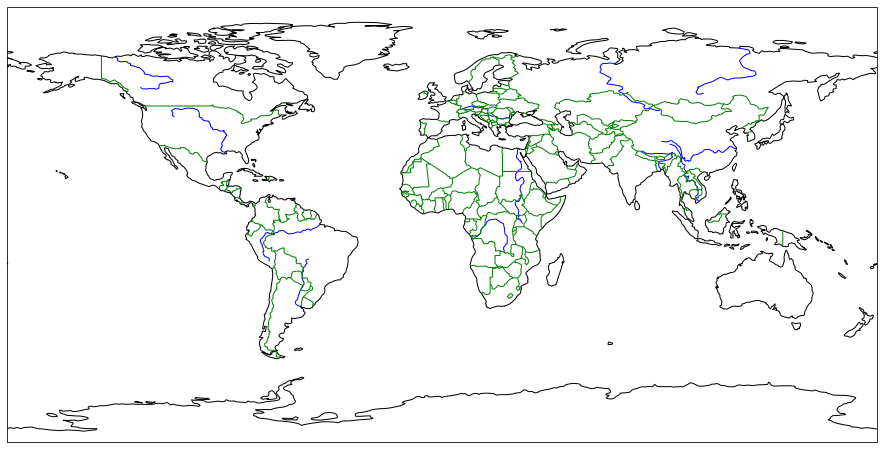

In [10]:
# Example showing map
def setup_base_map():
    plt.figure(figsize=(24, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()

    ax.add_feature(geofeatures.RIVERS, edgecolor='blue', facecolor='none')
    ax.add_feature(geofeatures.BORDERS, edgecolor='green', facecolor='none')
    return ax
setup_base_map()

In [11]:
DATA_LOCATION = 'examples/geo_data.csv'if not GCOLAB else '/content/drive/Shareddrives/DO3SE/data/geo_data.csv'
data = pd.read_csv(DATA_LOCATION)
data.head()


,Unnamed: 0,Cell_ID,row,column,lat,long,crop,subcrop,area,start,end
0,18944,1432545,332,2625,62.375000,38.708332,1,1,0.001184,9,8
1,19830,1436873,333,2633,62.291668,39.375000,1,1,0.001048,9,8
2,20708,1441193,334,2633,62.208332,39.375000,1,1,0.003347,9,8
3,20747,1441199,334,2639,62.208332,39.875000,1,1,0.001117,9,8
4,21668,1445505,335,2625,62.125000,38.708332,1,1,0.007520,9,8


In [12]:
china_data = data[(data["lat"] > 7) & (data["lat"]< 43) & (data["long"] > 86) & (data["long"] < 133)]
china_data.head()

,Unnamed: 0,Cell_ID,row,column,lat,long,crop,subcrop,area,start,end
133907,4487699,2439698,565,3218,42.958332,88.125000,1,1,62.635231,10,4
133908,4487754,2439709,565,3229,42.958332,89.041664,1,1,93.771332,10,4
133909,4487783,2439710,565,3230,42.958332,89.125000,1,1,306.062775,10,4
133910,4487812,2439711,565,3231,42.958332,89.208336,1,1,56.734360,10,4
133911,4487855,2439715,565,3235,42.958332,89.541664,1,1,246.849228,10,4


In [13]:
china_data_sample = china_data.sample(n=1000)

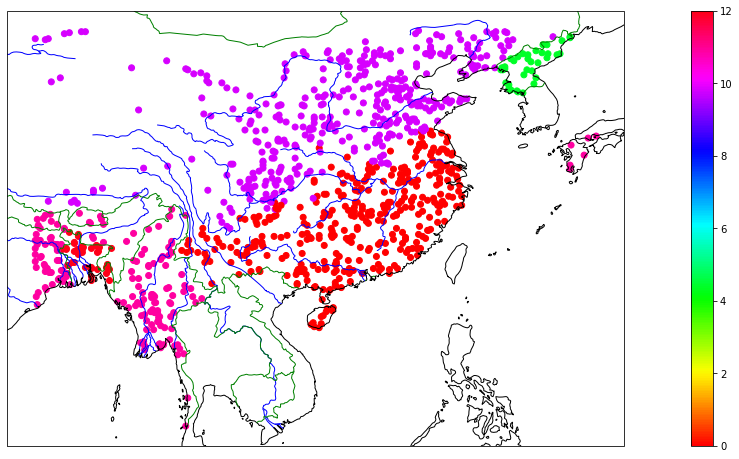

In [14]:
# MIRCA 2000 data
ax = setup_base_map()
cmap = plt.cm.hsv
range = 12
z = china_data_sample["start"] / range
minsgs = china_data_sample["start"].min()
maxsgs = china_data_sample["start"].max()
ax.scatter(china_data_sample['long'], china_data_sample['lat'], c=z, cmap=cmap)


sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=range))
plt.colorbar(sm)
plt.show()

In [15]:
import matplotlib.colors as colors
# https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [16]:
def map_sgs(
    sgs_data,
    lat_data,
    lon_data,
):
    ax = setup_base_map()
    z = sgs_data / 365
    cmap = plt.cm.hsv
    minsgs = sgs_data.min()
    maxsgs = sgs_data.max()

    new_cmap = truncate_colormap(cmap, minsgs/365, maxsgs/365)
    sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=plt.Normalize(vmin=minsgs, vmax=maxsgs))
    plt.colorbar(sm)

    ax.scatter(china_data_sample['long'], china_data_sample['lat'], c=z, cmap=new_cmap)
    

In [17]:

@interact_plus_reset(
    a = widgets.FloatSlider(value=105, min=1, max=2000, step=1), 
    b = widgets.FloatSlider(value=297, min=1, max=2000, step=1),
    c = widgets.FloatSlider(value=1.5, min=1, max=4, step=0.1),
    d = widgets.FloatSlider(value=2.0, min=1, max=10, step=0.1),
    e = widgets.FloatSlider(value=1000, min=1, max=2000, step=1),
    f = widgets.FloatSlider(value=50, min=1, max=2000, step=1),
)
def get_sgs(a,b,c,d,e,f):
    elev=0
    china_sgs_egs = china_data_sample.apply(lambda row: pd.Series(estimate_latitude_SGS_EGS(
        lat=row.lat,
        elev=elev,
        a=a,
        b=b,
        c=c,
        d=d,
        e=e,
        f=f,
    ), index=["sgs", "egs"]), axis=1)
    map_sgs(china_sgs_egs["sgs"], china_data_sample["lat"], china_data_sample["long"])
    
    plt.show()



Button(description='Reset', style=ButtonStyle())

Output()